In [1]:
import matplotlib.gridspec as gridspec
import scqubits
import numpy as np
from CoupledQuantumSystems.visualization import *
from CoupledQuantumSystems.systems import *
from tqdm import tqdm
import pickle
import scipy
from CoupledQuantumSystems.qobj_manip import *
from matplotlib.ticker import ScalarFormatter
import scipy
from skimage.transform import radon
import numpy as np
from CoupledQuantumSystems.mcsolve_utils import *
import matplotlib.pyplot as plt

from scqubits.settings import matplotlib_settings
import matplotlib as mpl
from matplotlib.axes import Axes
from scqubits.utils.plot_utils import _extract_kwargs_options
from numpy import ndarray
from scqubits.utils.misc import InfoBar, process_which
import scqubits.core.constants as constants
from scqubits.utils.spectrum_utils import (
    get_matrixelement_table,
    order_eigensystem,
    recast_esys_mapdata,
    standardize_sign,
)
from scqubits.utils.plot_utils import (
    _extract_kwargs_options,
    _process_options,
    add_numbers_to_axes,
    color_normalize,
    plot_potential_to_axes,
    plot_wavefunction_to_axes,
    scale_wavefunctions,
)
import scqubits.utils.misc as utils
from scqubits.core.discretization import Grid1d
from typing import List
import matplotlib.gridspec as gridspec

import sys
original_sys_path = sys.path.copy()
from CoupledQuantumSystems.visualization import *
import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
ef_system = '../ef_larger_drive/ef_mcsolve_system_g0.2.pkl'
gf_system = '../gf_new/gf_mcsolve_system_g3a01k002.pkl'
ef_results = '../ef_larger_drive/mcsolve_results_with_product_basis_second_batch.pkl'
gf_results = '../gf_new/mcsolve_results_with_product_basis.pkl'
ef_SNR =  '../ef_larger_drive/numbers_for_SNR_g2a015k003.pkl'
gf_SNR = '../gf_new/numbers_for_SNR.pkl'
with open(ef_system, 'rb') as f:
    system_ef = pickle.load(f)
qbt0 = system_ef.qbt
with open(gf_system, 'rb') as f:
    system_gf = pickle.load(f)
qbt1 = system_gf.qbt
with open(ef_results, 'rb') as f:
    results_ef = pickle.load(f)
with open(gf_results, 'rb') as f:
    results_gf = pickle.load(f)


with open('../ef_larger_drive/husimi_data_time_slices_5step_g2a015k003.pkl', 'rb') as f:
    ef_qfunc_results = pickle.load(f)
with open('../gf_new/husimi_data_time_slices.pkl', 'rb') as f:
    gf_qfunc_results = pickle.load(f)

In [3]:

linestyles = ['-','-','-']
linewidth_list = [1.75,1.75,1.75]

colors = ['#4999c3','#d5373d','#6cbe80']

In [4]:
@mpl.rc_context(matplotlib_settings)
def plot_wavefunction(
    qbt,
    phi_grid,
    which = 0,
    colors = None,
    fill = List[bool],
    dashed = List[bool],
    lw = List[float],
    mode= "real",
    scaling = None,
    fig_ax = None,
):
    if fill is None:
        fill = [False for i in colors]
    if dashed is None:
        dashed = [False for i in colors]
    if lw is None:
        lw = [1.0 for i in colors]
    wavefunc_indices = process_which(which, qbt.truncated_dim)

    evals_count = max(wavefunc_indices) + 1
    esys = qbt.eigensys(evals_count=evals_count)
    evals, _ = esys

    if colors == None:
        colors = ['grey' for _ in range(len(evals))]

    energies = evals[list(wavefunc_indices)]

    potential_vals = qbt.potential(phi_grid.make_linspace())

    amplitude_modifier = constants.MODE_FUNC_DICT[mode]
    wavefunctions = []
    for wavefunc_index in wavefunc_indices:
        phi_wavefunc = qbt.wavefunction(
            esys, which=wavefunc_index, phi_grid=phi_grid
        )
        phi_wavefunc.amplitudes = standardize_sign(phi_wavefunc.amplitudes)
        phi_wavefunc.amplitudes = amplitude_modifier(phi_wavefunc.amplitudes)
        wavefunctions.append(phi_wavefunc)

    wavefunction1d(
        wavefunctions,
        potential_vals=potential_vals,  # type:ignore
        offset=energies,
        scaling=scaling,
        colors = colors,
        fill = fill,
        dashed = dashed,
        lw=lw,
        fig_ax = fig_ax
    )
    return fig_ax

@mpl.rc_context(matplotlib_settings)
def wavefunction1d(
    wavefuncs,
    potential_vals,
    offset,
    scaling,
    colors,
    fill,
    dashed,
    lw,
    fig_ax
):

    fig, axes = fig_ax
    offset_list = utils.to_list(offset)
    wavefunc_list = utils.to_list(wavefuncs)
    wavefunc_list = scale_wavefunctions(wavefunc_list, potential_vals, scaling)

    for wavefunction, energy_offset,color,fill_this,dash_this,lw_this in zip(wavefunc_list, offset_list,colors,fill,dashed,lw):
        plot_wavefunction_to_axes(axes, wavefunction, energy_offset,color=color,fill_this=fill_this,dash_this=dash_this,lw_this=lw_this)

    x_vals = wavefunc_list[0].basis_labels
    plot_potential_to_axes(axes, x_vals, potential_vals, offset_list)
    return fig, axes

@mpl.rc_context(matplotlib_settings)
def plot_wavefunction_to_axes(
    axes,
      wavefunction,
      energy_offset,
      color,
      fill_this,
      dash_this,
      lw_this
) -> None:
    x_vals = wavefunction.basis_labels
    y_vals = energy_offset + wavefunction.amplitudes
    offset_vals = [energy_offset] * len(x_vals)

    axes.plot(x_vals, y_vals,color = color, alpha=1.0,linestyle = '--' if dash_this else '-',linewidth = lw_this)
    if fill_this:
        axes.fill_between(
            x_vals, y_vals, offset_vals,color = color, alpha=0.5,where=(y_vals != offset_vals), interpolate=True
        )

@mpl.rc_context(matplotlib_settings)
def plot_potential_to_axes(
    axes,
    x_vals,
    potential_vals,
    offset_list,
) -> None:
    y_min = np.min(potential_vals)
    y_max = np.max(offset_list)
    y_range = y_max - y_min
    y_max += 0.3 * y_range
    y_min = np.min(potential_vals) - 0.1 * y_range
    axes.set_ylim([y_min, y_max])
    axes.plot(
        x_vals, potential_vals, color="grey", linewidth=1.5
    )


In [5]:
n_evals = 20
qls = [0,1,2]
max_ol = 50
max_ql = 20

In [6]:
def plot_sweep_er_ef(ax):
    matrix0 =  qbt0.matrixelement_table(operator = "n_operator",evals_count=n_evals)
    g = 0.2
    evals0 = qbt0.eigenvals(n_evals)
    Er_list0 = np.linspace(6.2,7.0,int(1e4))
    for ql  in qls:
        shift_from_qubit_transition = []
        for Er in tqdm(Er_list0, desc = "Er loop"):
            shifts = [get_shift_accurate(matrix0[ql,ql2], evals0[ql2], evals0[ql], Er) for ql2 in range(n_evals)] 
            shift_from_qubit_transition.append(sum(shifts)*100 * g)
        ax.plot(Er_list0,np.array(shift_from_qubit_transition), label=rf'$\chi_{ql}$',color = colors[ql], linestyle = linestyles[ql],linewidth = linewidth_list[ql])
    ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    ax.set_xlim(Er_list0[0],Er_list0[-1])
    ax.set_ylim(0.5,2)
    ax.set_xlabel(rf'$\omega_r$')
    ax.legend(loc= 'lower left')
    ax.set_xlabel(rf'$\omega_r$ (GHz)')
    ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()])
    ax.set_ylabel(r'$\chi/2\pi$ (MHz)')
    ax.scatter(6.8,1.15, marker='*', color='black', s=80,alpha=0.5,zorder=10)

    y_offset = 1.75
    x_offset = 0.01
    ax.text(evals0[9]-evals0[2]+x_offset,y_offset,'2-9',color = colors[2],fontweight='bold')
    ax.text(evals0[10]-evals0[1]+x_offset, y_offset,'1-10',color = colors[1],fontweight='bold')
    ax.text(evals0[7]-evals0[0]+x_offset, y_offset,'0-7',color = colors[0],fontweight='bold')
    ax.text(evals0[11]-evals0[2]+x_offset, y_offset,'2-11',color = colors[2],fontweight='bold')

def plot_sweep_er_gf(ax):
    evals1 = qbt1.eigenvals(n_evals)
    matrix1 =  qbt1.matrixelement_table(operator = "n_operator",evals_count=n_evals)
    g= 0.3
    Er_list1 = np.linspace(11,16,int(1e4))
    for ql  in qls:
        shift_from_qubit_transition = []
        for Er in tqdm(Er_list1, desc = "Er loop"):
            shifts = [get_shift_accurate(matrix1[ql,ql2], evals1[ql2], evals1[ql], Er) for ql2 in range(n_evals)] 
            shift_from_qubit_transition.append(sum(shifts)*100*g)
        ax.plot(Er_list1, np.array(shift_from_qubit_transition), label=rf'$\chi_{ql}$',color = colors[ql], linestyle = linestyles[ql],linewidth = linewidth_list[ql])

    ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    ax.set_xlim(Er_list1[0],Er_list1[-1])
    ax.set_ylim(-1,1.5)
    ax.set_xlabel(rf'$\omega_r$')
    ax.legend(loc= 'lower left')
    ax.set_xlabel(rf'$\omega_r$ (GHz)')
    ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()])
    ax.set_ylabel(r'$\chi/2\pi$ (MHz)')
    ax.scatter(13.6355,0.32, marker='*', color='black', s=80,alpha=0.5,zorder=10)
    y_offset = 1
    x_offset = 0.006
    ax.text((evals1[9]-evals1[2]+x_offset),  y_offset,'2-9',color = colors[2],fontweight='bold')
    ax.text((evals1[10]-evals1[1]+x_offset), y_offset,'1-10',color = colors[1],fontweight='bold')
    ax.text((evals1[9]-evals1[0]+x_offset), y_offset,'0-9',color = colors[0],fontweight='bold')   
    ax.text((evals1[11]-evals1[2]+x_offset), y_offset,'2-11',color = colors[2],fontweight='bold')

In [7]:
def plot_ef_alpha(ax):
    epsilon_r = 0.015 *2*np.pi # External driving term
    kappa = 3e-3 # Decay rate of the resonator
    tot_time =400
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 346
    w_d = 6.798175922599341
    frequency_used = -1*w_d
    alpha_arr = (results_ef[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag, color='#4999c3',label = rf'$\alpha_{{\left|0\right>}}$ sim',alpha=1)
    alpha_arr = (results_ef[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag, color='#d5373d',label = rf'$\alpha_{{\left|1\right>}}$ sim',alpha=1)

    ax.set_aspect('equal')
    ax.set_xlabel(rf'Re[$\alpha$]')
    ax.set_ylabel(rf'Im[$\alpha$]', labelpad=-6)
    # ax.legend(loc = 'upper left',prop={'size': 9})
    ax.set_xlim(-11.5,2.5)
    ax.set_ylim(-11,3)
    # ax.set_yticks([0,-4,-8])

def plot_gf_alpha(ax):
    epsilon_r = 0.01*2*np.pi  # External driving term
    kappa = 2e-3 # Decay rate of the resonator
    tot_time =500
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 449
    w_d = 13.6355
    frequency_used = -1* w_d
    alpha_arr = (results_gf[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist)  )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag,color="#4999c3",label = rf'$\alpha_{{\left|0\right>}}$ sim',alpha=1)
    alpha_arr = (results_gf[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag,color="#d5373d",label = rf'$\alpha_{{\left|1\right>}}$ sim',alpha=1)

    ax.set_aspect('equal')
    ax.set_xlabel(rf'Re[$\alpha$]')
    ax.set_ylabel(rf'Im[$\alpha$]', labelpad=-6)
    # ax.legend(loc = 'lower right',prop={'size': 9})
    ax.set_xlim(-2.5,11)
    ax.set_ylim(-8,5.5)
    # ax.set_yticks([5, 0,-5,-10])

lim = 25
xvec = np.linspace(-1*lim,lim,500)
X, Y = np.meshgrid(xvec, xvec)

def plot_qfunc_cdf_contours(ax, q_values,levels = [0.001,0.5,0.99, 0.999],color='black'):
    sorted_q = np.sort(q_values.ravel())
    cumulative_sum = np.cumsum(sorted_q)
    total_sum = cumulative_sum[-1]
    for prob in levels:
        alpha = np.sqrt(1-prob)
        level_value = sorted_q[np.argmax(cumulative_sum >= total_sum * (1 - prob))]
        # fmt = {level_value:f'{1 - prob:.2f}'}   
        contour = ax.contour(X, Y, q_values, levels=[level_value], colors=color,alpha=alpha)
        # ax.clabel(contour, inline=False, fontsize=8, fmt=fmt,colors='black') 

level_to_draw = [0.1,0.5,0.9,0.99]
def plot_ef_qfunc(ax):
    t_indices = [0, 70, 140, 210, 280, 346]
    for t_idx,result in zip(t_indices,ef_qfunc_results):
        q_values_leak, q_values_compu0, q_values_compu1,  theta,y_leak, y_compu0, y_compu1  = result
        plot_qfunc_cdf_contours(ax, q_values_leak,levels = level_to_draw,color = '#4999c3')
        plot_qfunc_cdf_contours(ax, q_values_compu0,levels = level_to_draw,color = "#d5373d")

def plot_gf_qfunc(ax):
    t_indices = [0, 90, 180, 270, 360, 449]
    for t_idx,result in zip(t_indices,gf_qfunc_results):
        q_values_leak, q_values_compu0, q_values_compu1,  theta,y_leak, y_compu0, y_compu1  = result
        plot_qfunc_cdf_contours(ax, q_values_leak,levels = level_to_draw,color = "#4999c3")
        plot_qfunc_cdf_contours(ax, q_values_compu0,levels = level_to_draw,color = '#d5373d')

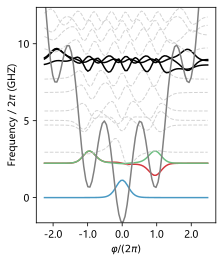

In [10]:
fig = plt.figure(figsize=(10, 7.5))

first_row_bottom = 0.767
second_row_bottom = 0.5
chi_height = 0.17
alpha_height = 0.23
chi_left = 4.35/7
chi_right = 5.35/7
alpha_left = 5.7/7
alpha_right = 7/7


gs_wavefunction = fig.add_gridspec(nrows=1, ncols=1,left=0.05, right=0.3,bottom=second_row_bottom+0.05,top = 0.95)
ax_wavefunction = fig.add_subplot(gs_wavefunction[0])

# # Chi
# chi_bottom_padding = 0.04
# gs_chi_ef = fig.add_gridspec(nrows=1, ncols=1,left=chi_left, right=chi_right,bottom=first_row_bottom+chi_bottom_padding,top = first_row_bottom+chi_bottom_padding+chi_height)
# gs_chi_gf = fig.add_gridspec(nrows=1, ncols=1,left=chi_left, right=chi_right,bottom=second_row_bottom+chi_bottom_padding,top = second_row_bottom+chi_bottom_padding+chi_height)
# ax0 = fig.add_subplot(gs_chi_ef[0])
# ax1 = fig.add_subplot(gs_chi_gf[0])

# # Alpha
# gs_alpha_ef = fig.add_gridspec(nrows=1, ncols=1,left=alpha_left, right=alpha_right, bottom=first_row_bottom,top = first_row_bottom+alpha_height)
# ax_alpha_ef = fig.add_subplot(gs_alpha_ef[0])
# gs_alpha_gf = fig.add_gridspec(nrows=1, ncols=1,left=alpha_left, right=alpha_right, bottom=second_row_bottom,top = second_row_bottom+alpha_height)
# ax_alpha_gf = fig.add_subplot(gs_alpha_gf[0])

# gs_dispersive_shift_illustration = fig.add_gridspec(nrows=1, ncols=1,left=0.32, right=0.55, bottom=0.5,top = 0.95)
# ax_dispersive_shift_illustration = fig.add_subplot(gs_dispersive_shift_illustration[0])
# ax_dispersive_shift_illustration.text(0,0.0, r'$|g0\rangle$', fontsize=11, va='top', color='#4999c3')
# ax_dispersive_shift_illustration.text(0,0.2, r'$|g1\rangle$', fontsize=11, va='top', color='#4999c3')
# ax_dispersive_shift_illustration.text(0,0.4, r'$|7_q 0_r\rangle$', fontsize=11, va='top', color='#4999c3')
# ax_dispersive_shift_illustration.text(0,0.6, r'$\chi_g = -1\times 2\pi$ MHz', fontsize=11, va='top', color='#4999c3')
# ax_dispersive_shift_illustration.text(0,0.8, r'$|9_q 0_r\rangle$', fontsize=11, va='top', color='#4999c3')

# ax_dispersive_shift_illustration.text(0.33,0.0, r'$|e0\rangle$', fontsize=11, va='top', color='#d5373d')
# ax_dispersive_shift_illustration.text(0.33,0.2, r'$|e1\rangle$', fontsize=11, va='top', color='#d5373d')
# ax_dispersive_shift_illustration.text(0.33,0.4, r'$\chi_e$', fontsize=11, va='top', color='#d5373d')
# ax_dispersive_shift_illustration.text(0.33,0.5, r'$|10_q 0_r\rangle$', fontsize=11, va='top', color='#d5373d')

# ax_dispersive_shift_illustration.text(0.66,0.0, r'$|f0\rangle$', fontsize=11, va='top', color='#6cbe80')
# ax_dispersive_shift_illustration.text(0.66,0.2, r'$|f1\rangle$', fontsize=11, va='top', color='#6cbe80')
# ax_dispersive_shift_illustration.text(0.5,0.5, r'$\approx \chi_f 0.6 \times 2\pi$ MHz', fontsize=11, va='top', color='#6cbe80')
# ax_dispersive_shift_illustration.text(0.66,0.4, r'$|11_q 0_r\rangle$', fontsize=11, va='top', color='#6cbe80')
# ax_dispersive_shift_illustration.text(0.66,0.2, r'$|f1\rangle$', fontsize=11, va='top', color='#6cbe80')

# ax_dispersive_shift_illustration.text(0.33,0.7, r'$\chi_e = 3.8\times 2\pi$ MHz', fontsize=11, va='top', color='#4999c3')
# ax_dispersive_shift_illustration.text(0.5,0.8, r'$\approx \chi_f 0.4 \times 2\pi$ MHz', fontsize=11, va='top', color='#6cbe80')




# gs_photon_number_dependency = fig.add_gridspec(nrows=1, ncols=1,left=0.05, right=0.33, bottom=0.05,top = 0.45)
# ax_photon_number_dependency = fig.add_subplot(gs_photon_number_dependency[0])
# ax_photon_number_dependency.text(0.1,0.1, r'$|a0\rangle$', fontsize=11, va='top')
# ax_photon_number_dependency.text(0.1,0.2, r'$|a1\rangle$', fontsize=11, va='top')
# ax_photon_number_dependency.text(0.1,0.4, r'$|a2\rangle$', fontsize=11, va='top')
# ax_photon_number_dependency.text(0.1,0.6, r'$|b0\rangle$', fontsize=11, va='top')
# ax_photon_number_dependency.text(0.1,0.8, r'$|b1\rangle$', fontsize=11, va='top')
# ax_photon_number_dependency.text(0.1,0.9, r'$|b2\rangle$', fontsize=11, va='top')

# ax_photon_number_dependency.text(0.33,0.0, r'$\omega_q$', fontsize=11, va='top')
# ax_photon_number_dependency.text(0.33,0.2, r'$\omega_q+\Lambda$', fontsize=11, va='top')
# ax_photon_number_dependency.text(0.33,0.4, r'$\omega_q+2\Lambda$', fontsize=11, va='top')

# ax_photon_number_dependency.text(0.5,0.5, r'computational subspace measurement rate $\propto \kappa (\chi_a - \chi_b)^2$', fontsize=11, va='top')
# ax_photon_number_dependency.text(0.5,0.7, r'Phase smearing dephasing $\propto \Lambda^2$', fontsize=11, va='top')



qbt = system_ef.qbt
omega_0 = qbt.eigenvals()[0]
color_used = ['#4999c3', '#d5373d', '#6cbe80']+['lightgrey']*6 +['black']*3+ ['lightgrey']*4
dashed = [0]*3+[1]*6+[0]*3+[1]*4
fill = None
lw = [1.5]*3+[1.0]*6+[1.5]*3+[1.0]*4
fig, ax_wavefunction = plot_wavefunction( qbt, which=list(range(16)),colors = color_used,
                                                                fill = fill,
                                                                fig_ax =(fig, ax_wavefunction ),
                        scaling=0.4,
                        phi_grid=Grid1d(min_val=  -14.137166941154069*1, max_val= 14.137166941154069*1.1, pt_count= 80) ,
                        dashed =  dashed,lw=lw)
ax_wavefunction.set_ylim(-3,11)

ax_wavefunction.set_xticks(np.array([-2,-1,0,1,2])*2* np.pi)
current_ticks = ax_wavefunction.get_xticks()
modified_ticks = current_ticks /(2* np.pi)
ax_wavefunction.set_xticklabels([f'{val:.1f}' for val in modified_ticks])
ax_wavefunction.set_xlabel(r"$\varphi/(2\pi)$")

ax_wavefunction.set_yticks(np.array([0,5,10])+omega_0)
current_ticks = ax_wavefunction.get_yticks()
modified_ticks = current_ticks - omega_0
ax_wavefunction.set_yticklabels([f'{val:.0f}' for val in modified_ticks])
ax_wavefunction.set_ylabel(rf'''Frequency / $2\pi$ (GHZ)''',labelpad = 0)


# plot_sweep_er_ef(ax0)
# plot_sweep_er_gf(ax1)
# plot_ef_alpha(ax_alpha_ef)
# plot_ef_qfunc(ax_alpha_ef)
# plot_gf_alpha(ax_alpha_gf)
# plot_gf_qfunc(ax_alpha_gf)

# ax_alpha_gf.text(8,2.5,r'$\hat{Q}_{|0\rangle}$',fontsize=11,va='top',color = '#4999c3')
# ax_alpha_gf.text(8,4,r'$\hat{Q}_{|1\rangle}$',fontsize=11,va='top',color = '#d5373d')


# plt.text(-0.13, 1.02, '(a)', transform=plt.subplot(gs_chi_ef[0]).transAxes, fontsize=11, va='top', color='black')
# plt.text(-0.13, 1.02, '(b)', transform=plt.subplot(gs_chi_gf[0]).transAxes, fontsize=11, va='top', color='black')
# plt.text(-0.13, 1.02, '(c)', transform=plt.subplot(gs_alpha_ef[0]).transAxes, fontsize=11, va='top', color='black')
# plt.text(-0.13, 1.02, '(d)', transform=plt.subplot(gs_alpha_gf[0]).transAxes, fontsize=11, va='top', color='black')
plt.savefig("Fig2.pdf", transparent=True)

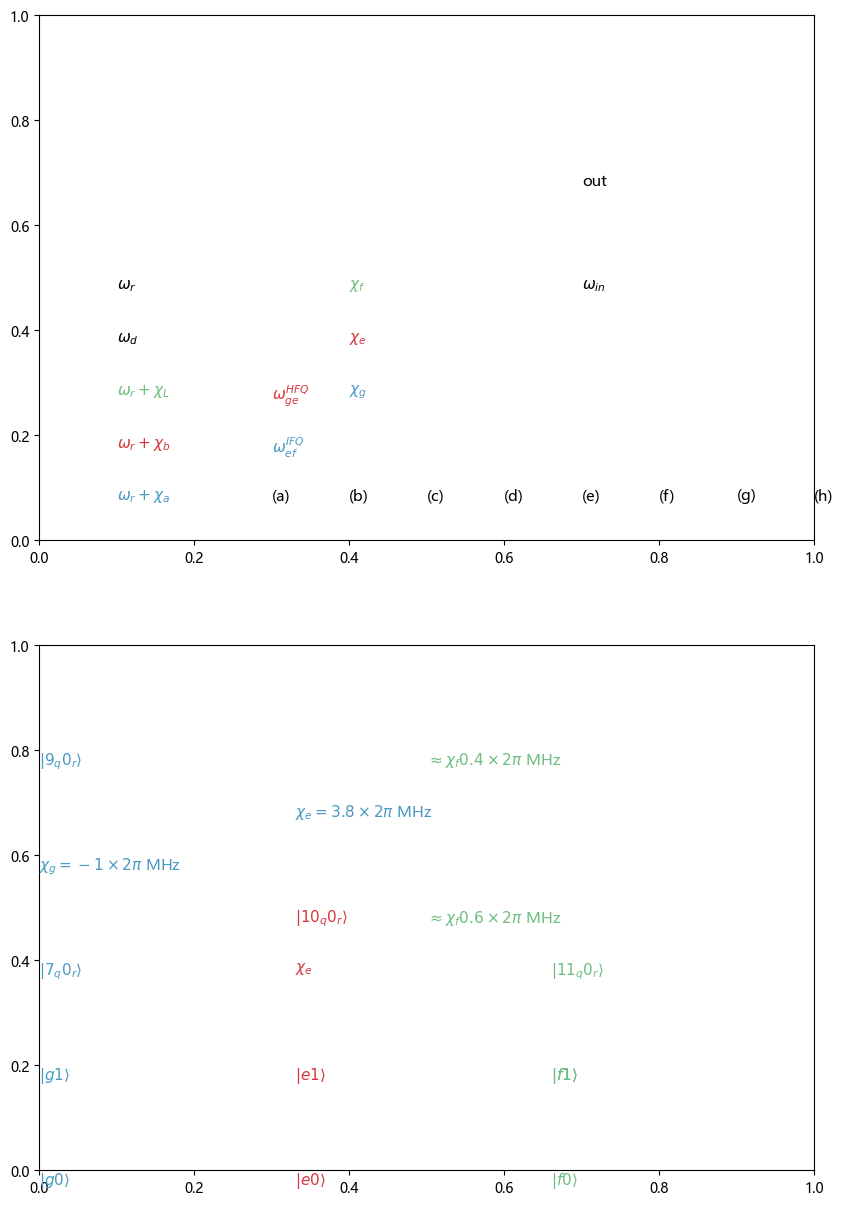

In [7]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(2,1,figsize=(10,15))
ax1,ax2 = axes
ax1.text(0.1,0.1,r"$\omega_r+\chi_a$",fontsize=11,va='top',color = '#4999c3')
ax1.text(0.1,0.2,r"$\omega_r+\chi_b$",fontsize=11,va='top',color = '#d5373d')
ax1.text(0.1,0.3,r"$\omega_r+\chi_L$",fontsize=11,va='top',color = '#6cbe80')

ax1.text(0.1,0.4,r"$\omega_d$",fontsize=11,va='top')

ax1.text(0.1,0.5,r"$\omega_r$",fontsize=11,va='top')

ax1.text(0.3,0.1,"(a)",fontsize=11,va='top')
ax1.text(0.4,0.1,"(b)",fontsize=11,va='top')
ax1.text(0.5,0.1,"(c)",fontsize=11,va='top')
ax1.text(0.6,0.1,"(d)",fontsize=11,va='top')
ax1.text(0.7,0.1,"(e)",fontsize=11,va='top')
ax1.text(0.8,0.1,"(f)",fontsize=11,va='top')
ax1.text(0.9,0.1,"(g)",fontsize=11,va='top')
ax1.text(1.0,0.1,"(h)",fontsize=11,va='top')


ax1.text(0.3,0.2,r"$\omega_{ef}^{IFQ}$",fontsize=11,va='top',color = '#4999c3')
ax1.text(0.3,0.3,r"$\omega_{ge}^{HFQ}$",fontsize=11,va='top',color = '#d5373d')

ax1.text(0.4,0.3,r"$\chi_g$",fontsize=11,va='top',color = '#4999c3')
ax1.text(0.4,0.4,r"$\chi_e$",fontsize=11,va='top',color = '#d5373d')
ax1.text(0.4,0.5,r"$\chi_f$",fontsize=11,va='top',color = '#6cbe80')

ax1.text(0.7,0.5,r"$\omega_{in}$",fontsize=11,va='top',)
ax1.text(0.7,0.7,r"out",fontsize=11,va='top',)


ax2.text(0,0.0, r'$|g0\rangle$', fontsize=11, va='top', color='#4999c3')
ax2.text(0,0.2, r'$|g1\rangle$', fontsize=11, va='top', color='#4999c3')
ax2.text(0,0.4, r'$|7_q 0_r\rangle$', fontsize=11, va='top', color='#4999c3')
ax2.text(0,0.6, r'$\chi_g = -1\times 2\pi$ MHz', fontsize=11, va='top', color='#4999c3')
ax2.text(0,0.8, r'$|9_q 0_r\rangle$', fontsize=11, va='top', color='#4999c3')

ax2.text(0.33,0.0, r'$|e0\rangle$', fontsize=11, va='top', color='#d5373d')
ax2.text(0.33,0.2, r'$|e1\rangle$', fontsize=11, va='top', color='#d5373d')
ax2.text(0.33,0.4, r'$\chi_e$', fontsize=11, va='top', color='#d5373d')
ax2.text(0.33,0.5, r'$|10_q 0_r\rangle$', fontsize=11, va='top', color='#d5373d')

ax2.text(0.66,0.0, r'$|f0\rangle$', fontsize=11, va='top', color='#6cbe80')
ax2.text(0.66,0.2, r'$|f1\rangle$', fontsize=11, va='top', color='#6cbe80')
ax2.text(0.5,0.5, r'$\approx \chi_f 0.6 \times 2\pi$ MHz', fontsize=11, va='top', color='#6cbe80')
ax2.text(0.66,0.4, r'$|11_q 0_r\rangle$', fontsize=11, va='top', color='#6cbe80')
ax2.text(0.66,0.2, r'$|f1\rangle$', fontsize=11, va='top', color='#6cbe80')

ax2.text(0.33,0.7, r'$\chi_e = 3.8\times 2\pi$ MHz', fontsize=11, va='top', color='#4999c3')
ax2.text(0.5,0.8, r'$\approx \chi_f 0.4 \times 2\pi$ MHz', fontsize=11, va='top', color='#6cbe80')




plt.savefig("Fig2.pdf", transparent=True)



